============================================================
# Notebook pentru preprocesarea datelor și selecția modelului
# Lucrare de licență – Sistem autonom pentru detecția riscurilor asupra sănătății

Acest notebook include:
- Curățarea și imputarea datelor
- Analiza corelațiilor și selecția trăsăturilor
- Scalarea și salvarea variantelor de seturi de date
- Antrenarea și evaluarea mai multor modele (RF, SVM, NN)
- Salvarea modelelor și a rezultatelor pentru integrarea în aplicația web

# Autor: Tofan Ionut Lucian.
An universitar: 2024–2025
============================================================

# SECTIUNEA 1
Prepararea datelor si corectarea valorilor


Importuri pentru bibliotecile necesare

In [ ]:
import pandas as pd
import numpy as np
import io
import os

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import plot_tree, export_graphviz

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, roc_auc_score
)

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

import pickle
from joblib import dump

from google.colab import files


Incarcam setul de date - https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [ ]:
uploaded = files.upload()

Saving heart.csv to heart.csv


In [ ]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Afisam informatii despre dataset , si daca avem valori lipsa.

In [ ]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    object 
dtypes: float64(1), int64(5), object(6)
memory usage: 86.2+ KB
None
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak          

Verificam valorile unice din df

In [ ]:

for col in df.columns:
    print(f"{col}: {df[col].unique()}")


Age: [40 49 37 48 54 39 45 58 42 38 43 60 36 44 53 52 51 56 41 32 65 35 59 50
 47 31 46 57 55 63 66 34 33 61 29 62 28 30 74 68 72 64 69 67 73 70 77 75
 76 71]
Sex: ['M' 'F']
ChestPainType: ['ATA' 'NAP' 'ASY' 'TA']
RestingBP: [140 160 130 138 150 120 110 136 115 100 124 113 125 145 112 132 118 170
 142 190 135 180 108 155 128 106  92 200 122  98 105 133  95  80 137 185
 165 126 152 116   0 144 154 134 104 139 131 141 178 146 158 123 102  96
 143 172 156 114 127 101 174  94 148 117 192 129 164]
Cholesterol: [289 180 283 214 195 339 237 208 207 284 211 164 204 234 273 196 201 248
 267 223 184 288 215 209 260 468 188 518 167 224 172 186 254 306 250 177
 227 230 294 264 259 175 318 216 340 233 205 245 194 270 213 365 342 253
 277 202 297 225 246 412 265 182 218 268 163 529 100 206 238 139 263 291
 229 307 210 329 147  85 269 275 179 392 466 129 241 255 276 282 338 160
 156 272 240 393 161 228 292 388 166 247 331 341 243 279 198 249 168 603
 159 190 185 290 212 231 222 235 320 187 266 287 40

La o scurta analiza a rezultatului observam o anomalie in date , anume coloana RestingBP , care are o valoare de 0 ; ne propunem sa observam de cate ori apare si sa luam o decizie in functie de asta, dar si pe coloana Target , 'HeartDisease' , o valoare '0s' , cel mai probabil o eroare umana; o corectam.

In [ ]:
df['HeartDisease'] =df['HeartDisease'].replace('0s', '0')

print(df['HeartDisease'].unique())
count=0
for restingbp in df['RestingBP']:
  if restingbp == 0:
    count+=1
print(count)

['0' '1']
1


Cea mai buna decizie in cazul acesta este stergerea pentru ca avem doar o valoare de 0; nu ne va afecta outputul

In [ ]:
df = df[df['RestingBP'] != 0]

Scurta verificare :

In [ ]:
print(df['RestingBP'].unique())

[140 160 130 138 150 120 110 136 115 100 124 113 125 145 112 132 118 170
 142 190 135 180 108 155 128 106  92 200 122  98 105 133  95  80 137 185
 165 126 152 116 144 154 134 104 139 131 141 178 146 158 123 102  96 143
 172 156 114 127 101 174  94 148 117 192 129 164]


Observam ca avem o parte din pacienti carora nu li s-a inregistrat nivelul de colesterol, deci vom incepe o procedura de inlocuire a valorilor nule.


Intrucat restul valorilor sunt destul de relevante pentru a fi pastrate
propunem inlocuirea cu mediana , pe grupuri (dupa sex si grupe de varsta)

Crearea unei coloane de grupare pentru vârstă (grupe de 10 ani)

In [ ]:
df.loc[:, "AgeGroup"] = (df["Age"] // 10) * 10


Calcularea medianei colesterolului pentru fiecare combinație de Sex și AgeGroup

In [ ]:
cholesterol_medians = df[df["Cholesterol"] > 0].groupby(["Sex","AgeGroup"])["Cholesterol"].median()

In [ ]:
cholesterol_medians

Sex  AgeGroup
F    30          210.0
     40          234.5
     50          269.5
     60          269.0
     70          265.0
M    20          223.5
     30          240.0
     40          238.0
     50          229.0
     60          246.0
     70          221.0
Name: Cholesterol, dtype: float64

Inlocuim valorile de 0 pentru colesterol, cu valoarea medianei pe grupuri de varsta si sex:

In [ ]:
def replace_zero_cholesterol(row):
    if row["Cholesterol"] == 0:
      return cholesterol_medians.get((row["Sex"], row["AgeGroup"]), df["Cholesterol"].median())
    return row["Cholesterol"]

df["Cholesterol"] = df.apply(replace_zero_cholesterol, axis=1)

Verificare dacă mai există valori de 0 în colesterol

In [ ]:
print("Număr de pacienți cu colesterol 0 după înlocuire:", (df["Cholesterol"] == 0).sum())

Număr de pacienți cu colesterol 0 după înlocuire: 0


Eliminam coloana temporara folosita pentru grupare

In [ ]:
df.drop(columns=["AgeGroup"], inplace=True)

In [ ]:
print(df.describe())

              Age   RestingBP  Cholesterol   FastingBS       MaxHR     Oldpeak
count  917.000000  917.000000   917.000000  917.000000  917.000000  917.000000
mean    53.509269  132.540894   243.410033    0.233370  136.789531    0.886696
std      9.437636   17.999749    53.620791    0.423206   25.467129    1.066960
min     28.000000   80.000000    85.000000    0.000000   60.000000   -2.600000
25%     47.000000  120.000000   214.000000    0.000000  120.000000    0.000000
50%     54.000000  130.000000   238.000000    0.000000  138.000000    0.600000
75%     60.000000  140.000000   269.000000    0.000000  156.000000    1.500000
max     77.000000  200.000000   603.000000    1.000000  202.000000    6.200000


Grafice pentru distributiile variabilelor , impartite in : categoriale si numerice

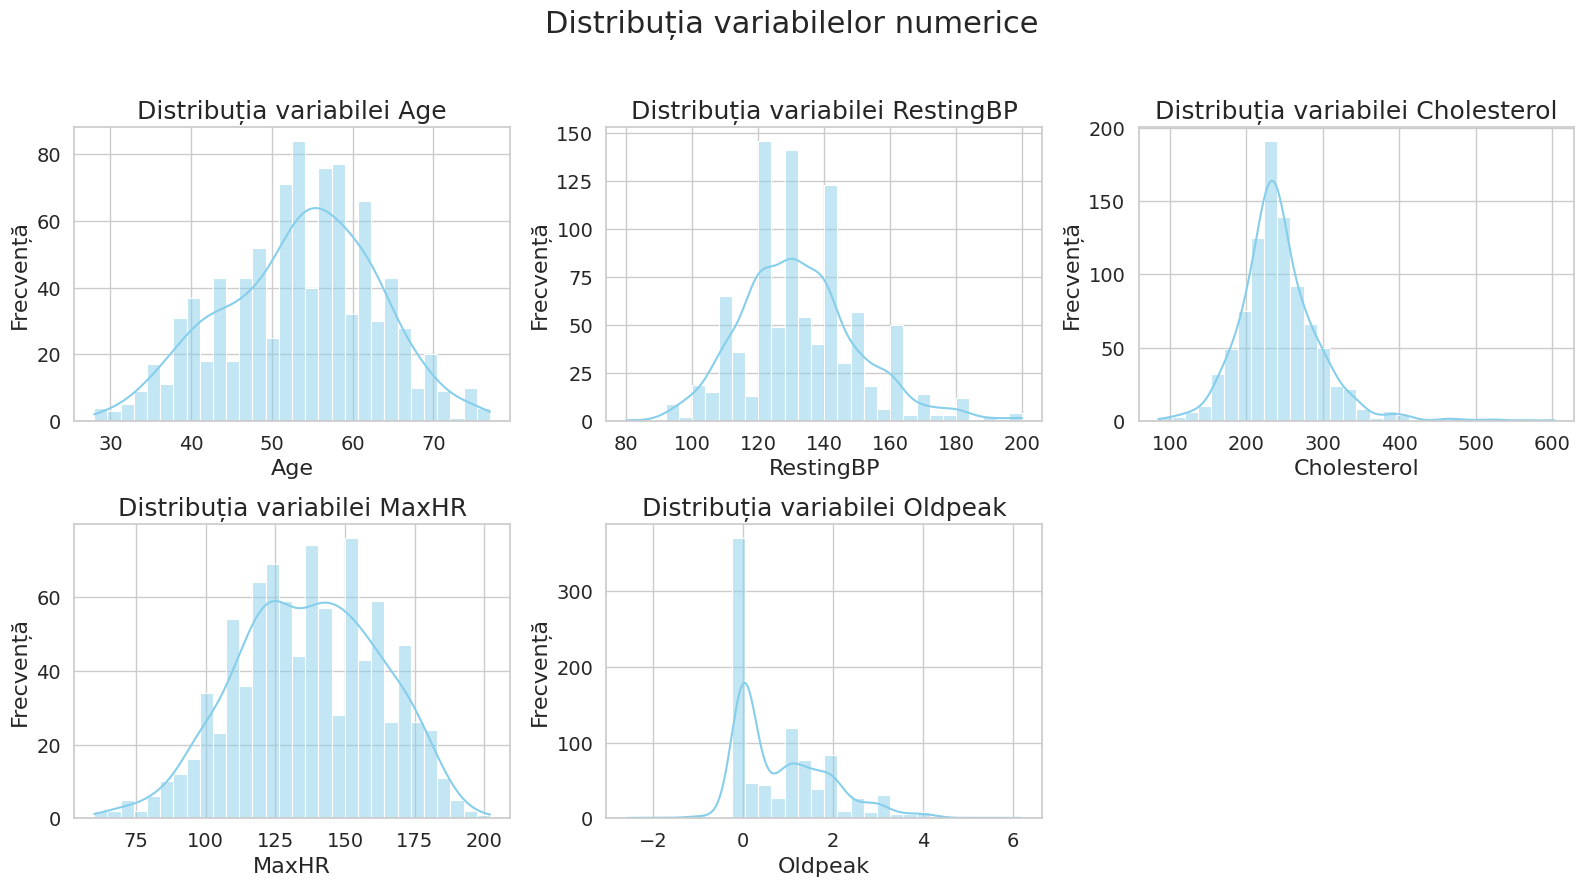

/tmp/ipython-input-16-4219212228.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=var, palette="pastel", edgecolor="black")
/tmp/ipython-input-16-4219212228.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=var, palette="pastel", edgecolor="black")
/tmp/ipython-input-16-4219212228.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=var, palette="pastel", edgecolor="black")
/tmp/ipython-input-16-4219212228.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be

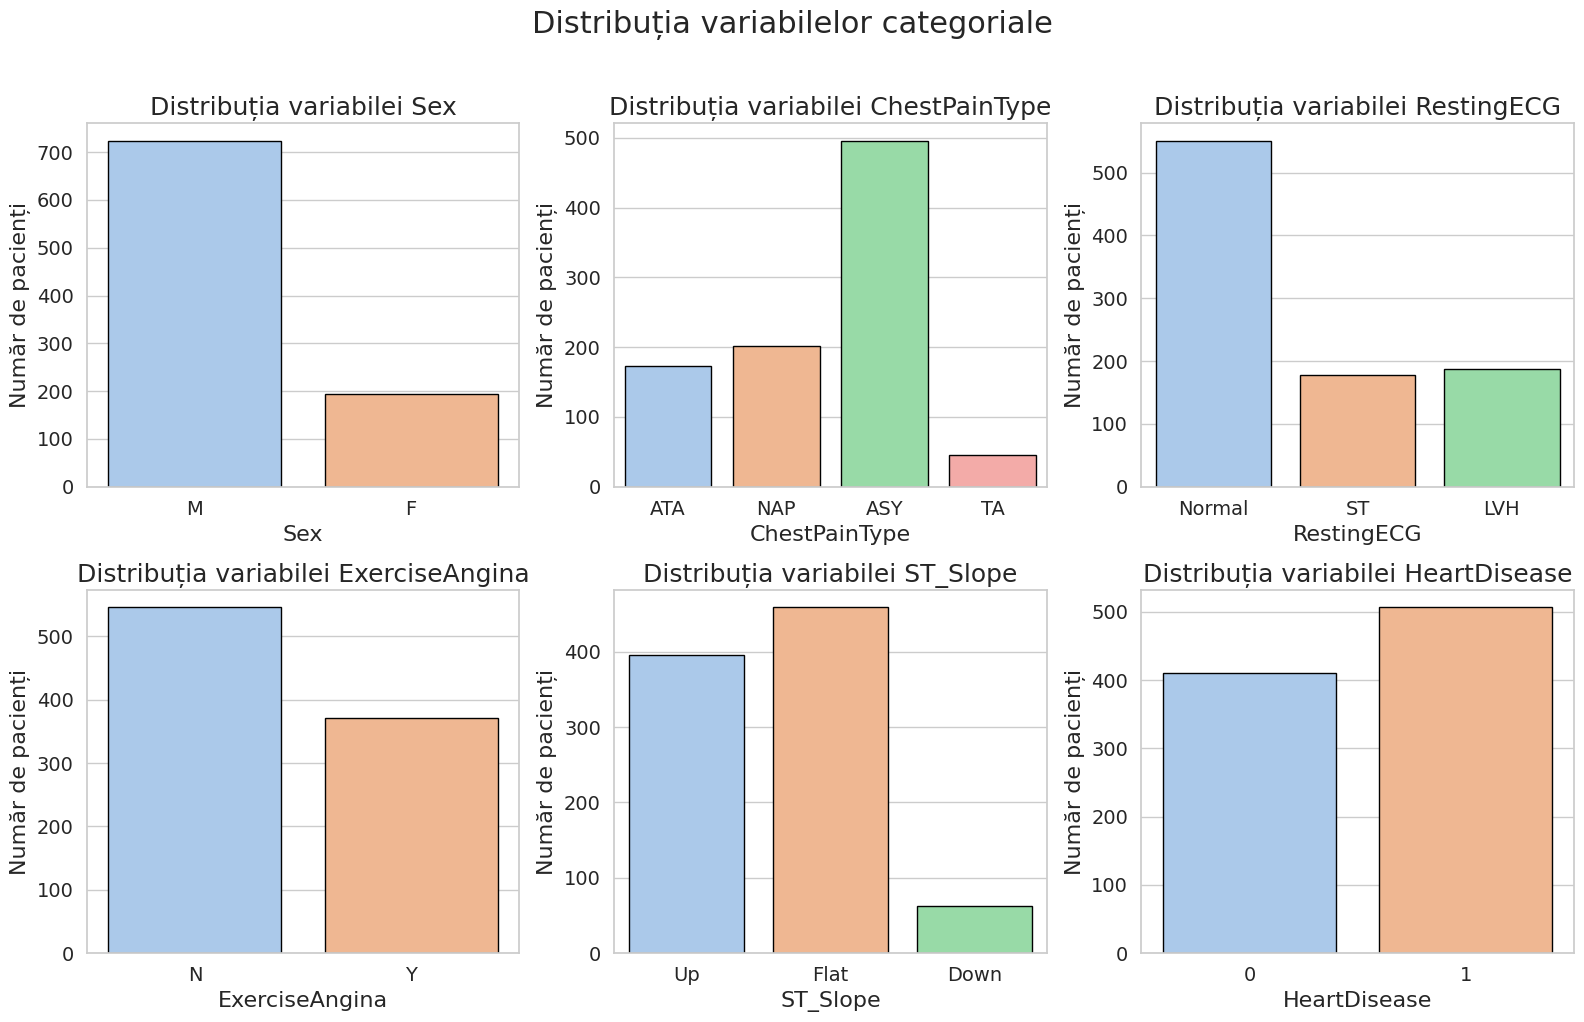

In [ ]:


sns.set(style="whitegrid")

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = numeric_cols.drop('FastingBS')

plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=col, kde=True, bins=30, color='skyblue')
    plt.title(f'Distribuția variabilei {col}', fontsize=18)
    plt.xlabel(col, fontsize=16)
    plt.ylabel('Frecvență', fontsize=16)
    plt.tick_params(axis='both', labelsize=14)

plt.suptitle("Distribuția variabilelor numerice", fontsize=22, y=1.02)
plt.tight_layout()
plt.savefig('distributie_numerice.png', dpi=300, bbox_inches='tight')
plt.show()


categorical_vars = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']

plt.figure(figsize=(16, 10))
for i, var in enumerate(categorical_vars, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=df, x=var, palette="pastel", edgecolor="black")
    plt.title(f"Distribuția variabilei {var}", fontsize=18)
    plt.xlabel(var, fontsize=16)
    plt.ylabel("Număr de pacienți", fontsize=16)
    plt.tick_params(axis='both', labelsize=14)

plt.suptitle("Distribuția variabilelor categoriale", fontsize=22, y=1.02)
plt.tight_layout()
plt.savefig('distributie_categoriale.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
Q1 = df['Cholesterol'].quantile(0.25)
Q3 = df['Cholesterol'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df[(df['Cholesterol'] >= lower_bound) & (df['Cholesterol'] <= upper_bound)]


df = df_clean.copy()

print(df.describe())

              Age   RestingBP  Cholesterol   FastingBS       MaxHR     Oldpeak
count  879.000000  879.000000   879.000000  879.000000  879.000000  879.000000
mean    53.425484  132.325370   239.541524    0.233220  136.883959    0.880432
std      9.421470   17.976666    40.726625    0.423122   25.638368    1.069490
min     28.000000   80.000000   132.000000    0.000000   60.000000   -2.600000
25%     47.000000  120.000000   214.000000    0.000000  120.000000    0.000000
50%     54.000000  130.000000   238.000000    0.000000  138.000000    0.500000
75%     60.000000  140.000000   265.000000    0.000000  156.000000    1.500000
max     77.000000  200.000000   349.000000    1.000000  202.000000    6.200000


In [ ]:
Q1 = df['Oldpeak'].quantile(0.25)
Q3 = df['Oldpeak'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean2 = df[(df['Oldpeak'] >= lower_bound) & (df['Oldpeak'] <= upper_bound)]
df = df_clean2.copy()
print(df.describe())

              Age   RestingBP  Cholesterol   FastingBS       MaxHR     Oldpeak
count  864.000000  864.000000   864.000000  864.000000  864.000000  864.000000
mean    53.364583  132.155093   239.361111    0.233796  136.964120    0.827662
std      9.425327   17.794475    40.719554    0.423489   25.692673    0.969482
min     28.000000   80.000000   132.000000    0.000000   60.000000   -2.000000
25%     47.000000  120.000000   214.000000    0.000000  119.750000    0.000000
50%     54.000000  130.000000   237.000000    0.000000  138.500000    0.500000
75%     60.000000  140.000000   264.250000    0.000000  156.000000    1.500000
max     77.000000  200.000000   349.000000    1.000000  202.000000    3.700000


In [ ]:
Q1 = df['RestingBP'].quantile(0.25)
Q3 = df['RestingBP'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean3 = df[(df['RestingBP'] >= lower_bound) & (df['RestingBP'] <= upper_bound)]
df = df_clean3.copy()
print(df.describe())

              Age   RestingBP  Cholesterol   FastingBS       MaxHR     Oldpeak
count  840.000000  840.000000   840.000000  840.000000  840.000000  840.000000
mean    53.272619  130.822619   238.735714    0.230952  137.089286    0.825595
std      9.476435   15.740240    40.610520    0.421693   25.558046    0.970384
min     28.000000   94.000000   132.000000    0.000000   60.000000   -2.000000
25%     47.000000  120.000000   213.000000    0.000000  119.750000    0.000000
50%     54.000000  130.000000   236.000000    0.000000  138.000000    0.500000
75%     60.000000  140.000000   264.000000    0.000000  156.000000    1.500000
max     77.000000  170.000000   349.000000    1.000000  202.000000    3.700000


Coloanele categoriale trebuie codate.(Sex,ChestPainType,RestingECG,ExerciseAngina,STslope)(nu putem antrena modele de clasificare fara ca aceste coloane sa fie codate)

Pentru sex,ExerciseAngina vom folosi o codare clasica

SEX: [M:1,F:0],

ExerciseAngina [N:0,Y:1]



In [ ]:
df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})
df['ExerciseAngina'] = df['ExerciseAngina'].map({'N': 0, 'Y': 1})

Verificare

In [ ]:
df.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289.0,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160,180.0,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130,283.0,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138,214.0,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150,195.0,0,Normal,122,0,0.0,Up,0


Avand un dataset destul de mic (900 intrari) , avem optiunea de a aplica one-hot-encoding pentru celelalte variabile categorice.
One-hot-encoding presupune spargerea coloanei categorice in mai multe coloane bool .

Acest procedeu poate imbunatati functionarea modelelor deoarece datele sunt mai logice.

EXEMPLU : ChestPainType : 'ATA' 'NAP' 'ASY' 'TA', se va transforma acum in 4 coloane . Daca pacientul este asimptomatic de exemplu, ASY va fi 1 iar celelalte vor fi nule.

Convertim valoarea HeartDisease din object in int.(este object din cauza valorii "0s")


In [ ]:
categorical_cols = ['ChestPainType', 'RestingECG', 'ST_Slope']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

df['HeartDisease']=df['HeartDisease'].astype(int)

In [ ]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 840 entries, 0 to 917
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                840 non-null    int64  
 1   Sex                840 non-null    int64  
 2   RestingBP          840 non-null    int64  
 3   Cholesterol        840 non-null    float64
 4   FastingBS          840 non-null    int64  
 5   MaxHR              840 non-null    int64  
 6   ExerciseAngina     840 non-null    int64  
 7   Oldpeak            840 non-null    float64
 8   HeartDisease       840 non-null    int64  
 9   ChestPainType_ASY  840 non-null    bool   
 10  ChestPainType_ATA  840 non-null    bool   
 11  ChestPainType_NAP  840 non-null    bool   
 12  ChestPainType_TA   840 non-null    bool   
 13  RestingECG_LVH     840 non-null    bool   
 14  RestingECG_Normal  840 non-null    bool   
 15  RestingECG_ST      840 non-null    bool   
 16  ST_Slope_Down      840 non-null

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289.0,0,172,0,0.0,0,False,True,False,False,False,True,False,False,False,True
1,49,0,160,180.0,0,156,0,1.0,1,False,False,True,False,False,True,False,False,True,False
2,37,1,130,283.0,0,98,0,0.0,0,False,True,False,False,False,False,True,False,False,True
3,48,0,138,214.0,0,108,1,1.5,1,True,False,False,False,False,True,False,False,True,False
4,54,1,150,195.0,0,122,0,0.0,0,False,False,True,False,False,True,False,False,False,True


# SECȚIUNEA 2
Separarea datelor si pregatirea lor pentru antrenament


In [ ]:
x = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']
print(x.head())
print(y.head())

   Age  Sex  RestingBP  Cholesterol  FastingBS  MaxHR  ExerciseAngina  \
0   40    1        140        289.0          0    172               0   
1   49    0        160        180.0          0    156               0   
2   37    1        130        283.0          0     98               0   
3   48    0        138        214.0          0    108               1   
4   54    1        150        195.0          0    122               0   

   Oldpeak  ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  \
0      0.0              False               True              False   
1      1.0              False              False               True   
2      0.0              False               True              False   
3      1.5               True              False              False   
4      0.0              False              False               True   

   ChestPainType_TA  RestingECG_LVH  RestingECG_Normal  RestingECG_ST  \
0             False           False               True       

VIZUALIZAREA DEPENDENTELOR CARACTERISTICILOR DE HEART_DISEASE SI  analiza bivariată față de target

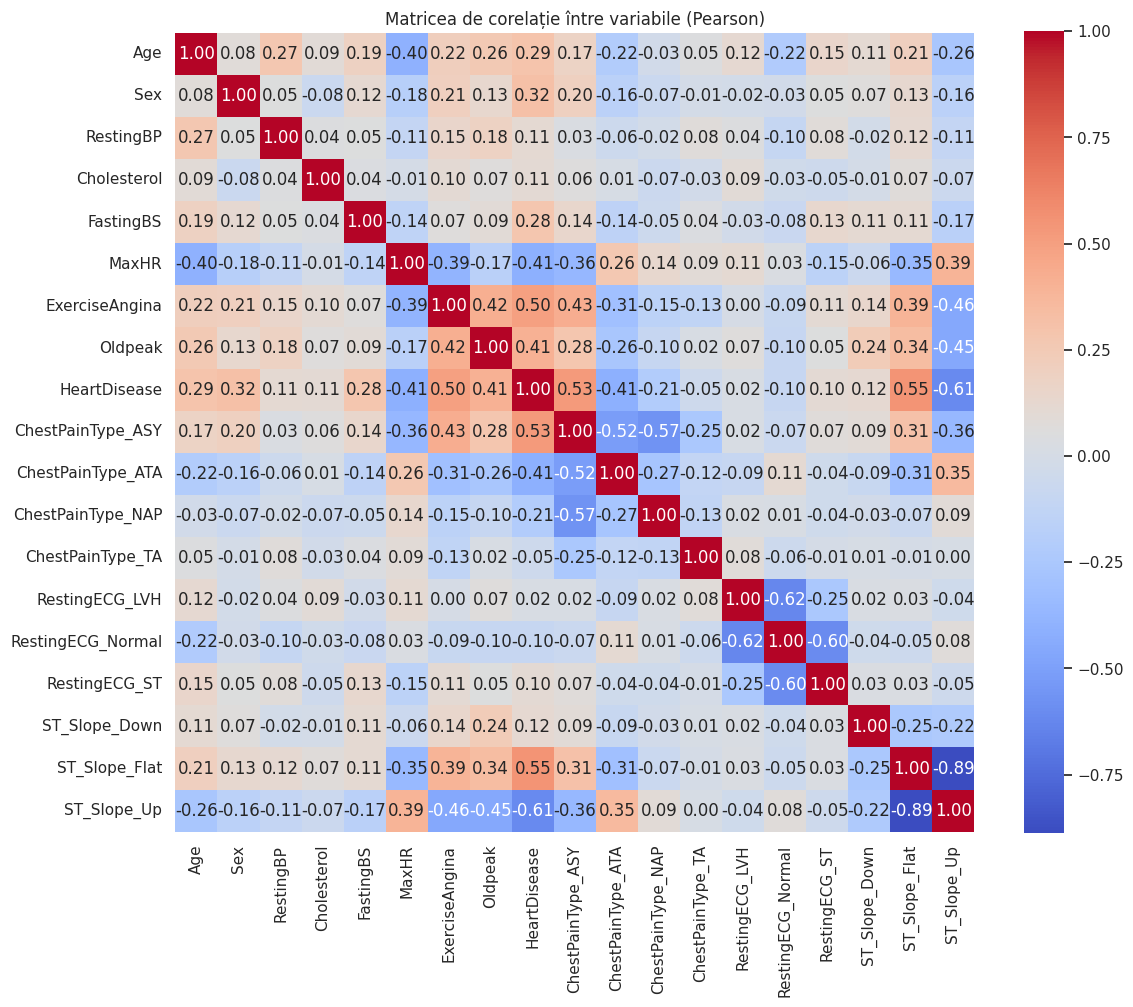

HeartDisease         1.000000
ST_Slope_Flat        0.552660
ChestPainType_ASY    0.527025
ExerciseAngina       0.498403
Oldpeak              0.409612
Sex                  0.318602
Age                  0.292621
FastingBS            0.281738
ST_Slope_Down        0.119760
RestingBP            0.112703
Cholesterol          0.105956
RestingECG_ST        0.103315
RestingECG_LVH       0.016145
ChestPainType_TA    -0.052405
RestingECG_Normal   -0.096643
ChestPainType_NAP   -0.209165
MaxHR               -0.411350
ChestPainType_ATA   -0.412459
ST_Slope_Up         -0.613169
Name: HeartDisease, dtype: float64


In [ ]:
corr_matrix = df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matricea de corelație între variabile (Pearson)")
plt.tight_layout()
plt.savefig("matrice_corelatie.png", dpi=300, bbox_inches='tight')
plt.show()

correlation_with_target = corr_matrix["HeartDisease"].sort_values(ascending=False)
print(correlation_with_target)

In [ ]:
mi_scores = mutual_info_classif(x, y, random_state=42)
mi_series = pd.Series(mi_scores, index=x.columns).sort_values(ascending=False)
print(mi_series)


ST_Slope_Up          0.228642
ST_Slope_Flat        0.145827
ChestPainType_ASY    0.138426
ExerciseAngina       0.124389
MaxHR                0.120938
Oldpeak              0.119287
ChestPainType_ATA    0.095388
Cholesterol          0.069964
Age                  0.065145
FastingBS            0.037040
Sex                  0.028390
RestingECG_ST        0.028273
RestingBP            0.020572
RestingECG_LVH       0.018393
RestingECG_Normal    0.012784
ST_Slope_Down        0.008635
ChestPainType_TA     0.003626
ChestPainType_NAP    0.000000
dtype: float64


Analiza datelor arata ca trebuie sa renuntam la cateva coloane care aduc doar dezavantaje in realizarea predictiilor, ST_Slope_Down ChestPainType_TA ChestPainType_NAP-vezi lucrarea Capitolul 2.3

In [ ]:
x.drop(columns=['ST_Slope_Down', 'ChestPainType_TA', 'ChestPainType_NAP'], inplace=True)

Pentru retelele neuronale , este necesara normalizarea datelor si vom folosi MinMaxScaler()

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(x)


Salvam scalerul pentru a ne fi de folos mai tarziu, cand va trebui ca acesta sa normalizeze date furnizate catre model

In [ ]:
with open('scaler1.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Salvam cele doua data-frames in caz ca le vom folosi mai tarziu

In [ ]:
unscaled_data=pd.DataFrame(x)
unscaled_data['target']=y.values
print(unscaled_data.info())

scaled_data = pd.DataFrame(X_scaled)
scaled_data['target'] = y.values
print(scaled_data.info())

unscaled_data.to_csv('unscaled_data.csv',index=False)
scaled_data.to_csv('scaled_data.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 840 entries, 0 to 917
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                840 non-null    int64  
 1   Sex                840 non-null    int64  
 2   RestingBP          840 non-null    int64  
 3   Cholesterol        840 non-null    float64
 4   FastingBS          840 non-null    int64  
 5   MaxHR              840 non-null    int64  
 6   ExerciseAngina     840 non-null    int64  
 7   Oldpeak            840 non-null    float64
 8   ChestPainType_ASY  840 non-null    bool   
 9   ChestPainType_ATA  840 non-null    bool   
 10  RestingECG_LVH     840 non-null    bool   
 11  RestingECG_Normal  840 non-null    bool   
 12  RestingECG_ST      840 non-null    bool   
 13  ST_Slope_Flat      840 non-null    bool   
 14  ST_Slope_Up        840 non-null    bool   
 15  target             840 non-null    int64  
dtypes: bool(7), float64(2), int64(7

Pregatim datele pe care vor fi antrenate modelele

In [ ]:
x=unscaled_data.drop(columns=['target'])
y=unscaled_data['target']

x_scaled=scaled_data.drop(columns=['target'])
y_scaled=scaled_data['target']

print(x.info())

<class 'pandas.core.frame.DataFrame'>
Index: 840 entries, 0 to 917
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                840 non-null    int64  
 1   Sex                840 non-null    int64  
 2   RestingBP          840 non-null    int64  
 3   Cholesterol        840 non-null    float64
 4   FastingBS          840 non-null    int64  
 5   MaxHR              840 non-null    int64  
 6   ExerciseAngina     840 non-null    int64  
 7   Oldpeak            840 non-null    float64
 8   ChestPainType_ASY  840 non-null    bool   
 9   ChestPainType_ATA  840 non-null    bool   
 10  RestingECG_LVH     840 non-null    bool   
 11  RestingECG_Normal  840 non-null    bool   
 12  RestingECG_ST      840 non-null    bool   
 13  ST_Slope_Flat      840 non-null    bool   
 14  ST_Slope_Up        840 non-null    bool   
dtypes: bool(7), float64(2), int64(6)
memory usage: 64.8 KB
None


Împărțim datele în seturi de antrenament și test

Vom avea 2 tipuri de date : Cele scalate pe care le vom folosi pentru retelele neuronale, si datele initiale care vor fi folosite in clasificatorii pe care ii vom implementa.Nu este nevoie sa folosim datele scalate, intrucat acestea nu aduc nici un avantaj modelelor.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=42)

De ce randomstate=42?

Numărul 42 este adesea folosit ca exemplu în Machine Learning datorită cărții ("The Hitchhiker’s Guide to the Galaxy"), unde 42 este "răspunsul la întrebarea fundamentală despre viață, univers și tot restul".

Chiar daca este un concept fictiv, majoritatea oamenilor in domeniul acesta il respecta intotdeauna.


Functia folosita pentru afisarea performantei modelelor , pentru ca acestea sa poata fi comparate.

In [ ]:
def print_metrics(y_pred, y_test, model_name="Model"):
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    print({model_name})
    print(f"Acuratete   : {acc:.4f}")
    print(f"Precizie    : {precision:.4f}")
    print(f"Recall      : {recall:.4f}")
    print(f"F1-Score    : {f1:.4f}")
    print(f"AUC-ROC     : {auc:.4f}")
    print("\nMatrice de confuzie:")
    print(confusion_matrix(y_test, y_pred))

Implementare Model Random Forest

In [ ]:

rf = RandomForestClassifier(random_state=42)

# Grilă de parametri
param_grid = {
    'n_estimators': [50,75, 100,150],
    'max_depth': [10,12,15,20,None],
    'min_samples_split': [2,4,5,10,15,20],
    'min_samples_leaf': [2, 3, 4],
    'criterion': ['gini','entropy'],
    'max_features': ['sqrt','log2']
}


# Configurare GridSearch
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1,
)

# Fit pe datele de antrenament
grid_search.fit(X_train, y_train)

# Modelul optim
best_rf = grid_search.best_estimator_

# Predictii
y_pred = best_rf.predict(X_test)

# Evaluare
print_metrics(y_pred, y_test, model_name="Random Forest")

print("\nParametrii optimi găsiți:")
print(grid_search.best_params_)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits

===== Random Forest =====
Acuratete   : 0.8988
Precizie    : 0.8704
Recall      : 0.9691
F1-Score    : 0.9171
AUC-ROC     : 0.8859

Matrice de confuzie:
[[57 14]
 [ 3 94]]

Parametrii optimi găsiți:
{'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
dump(best_rf, 'random_forest_model.joblib')

['random_forest_model.joblib']

metricile pe test:

In [ ]:
y_train_pred = best_rf.predict(X_train)

print_metrics(y_train_pred, y_train, model_name="Random Forest (Train)")


===== Random Forest (Train) =====
Acuratete   : 0.9152
Precizie    : 0.9059
Recall      : 0.9387
F1-Score    : 0.9220
AUC-ROC     : 0.9134

Matrice de confuzie:
[[278  35]
 [ 22 337]]


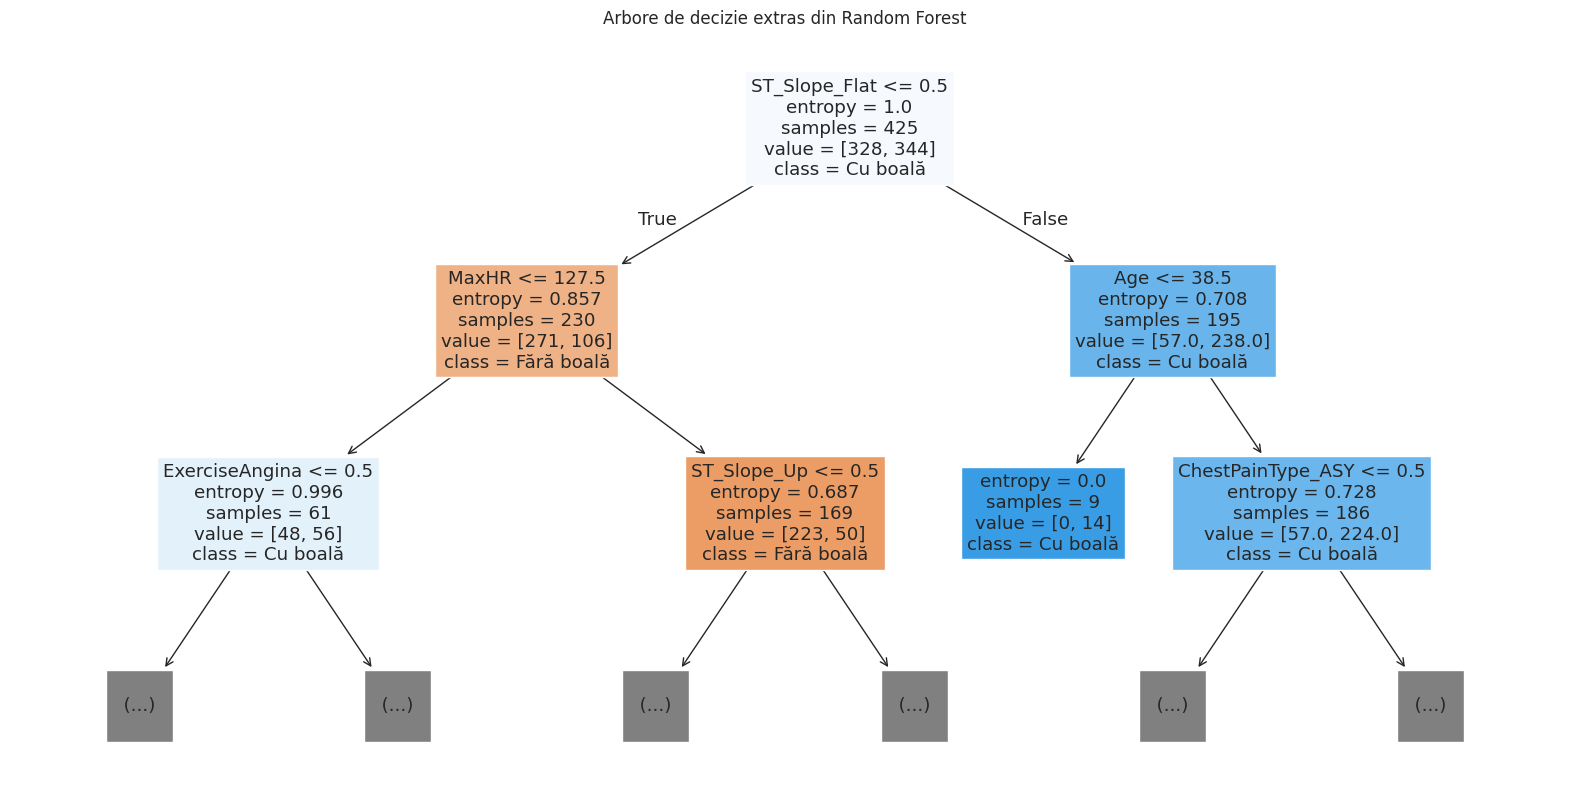

In [ ]:
estimator = best_rf.estimators_[0]  # primul arbore din padure

#vizualizare in mtlib
plt.figure(figsize=(20, 10))
plot_tree(estimator, filled=True, feature_names=X_train.columns, class_names=["Fără boală", "Cu boală"],max_depth=2)
plt.title("Arbore de decizie extras din Random Forest")
plt.savefig("arbore_rf.png", dpi=300)
plt.show()


Implementare Model SVM (Support Vector Machine) - acesta foloseste date scalate

In [ ]:

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': ['scale','auto', 0.001,0.01,0.1],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2,3],
}
0
grid = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_scaled_train, y_scaled_train)

print("Best Parameters:", grid.best_params_)

# Evaluezi modelul optimizat
best_svc = grid.best_estimator_
y_pred_svc = best_svc.predict(X_scaled_test)
print_metrics(y_pred_svc, y_scaled_test, "SVC Optimized")

Best Parameters: {'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}

===== SVC Optimized =====
Acuratete   : 0.8690
Precizie    : 0.8866
Recall      : 0.8866
F1-Score    : 0.8866
AUC-ROC     : 0.8658

Matrice de confuzie:
[[60 11]
 [11 86]]


In [ ]:
dump(best_svc, 'svc_model.joblib')

['svc_model.joblib']

Retea Neuronala Simpla (baseline)

  Avem un layer de input, cu numar de neuroni egal cu numarul de features, apoi un layer Dense , layer de dropout dupa fiecare layer dense pentru a preveni overfittingul, si un layer de output cu activare sigmoid
  

In [ ]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_scaled_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
nn_model.fit(X_scaled_train, y_scaled_train, epochs=40, batch_size=32, verbose=1, validation_split=0.2,callbacks=[callback])

y_pred_nn = nn_model.predict(X_scaled_test)
y_pred_nn = (y_pred_nn > 0.5).astype("int32")
print_metrics(y_pred_nn, y_scaled_test, "Neural Network 1")


Epoch 1/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5781 - loss: 0.6665 - val_accuracy: 0.8074 - val_loss: 0.5980
Epoch 2/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7970 - loss: 0.5706 - val_accuracy: 0.8370 - val_loss: 0.5105
Epoch 3/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8205 - loss: 0.4824 - val_accuracy: 0.8667 - val_loss: 0.4283
Epoch 4/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8476 - loss: 0.4155 - val_accuracy: 0.8741 - val_loss: 0.3819
Epoch 5/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8252 - loss: 0.4085 - val_accuracy: 0.8667 - val_loss: 0.3749
Epoch 6/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8616 - loss: 0.3315 - val_accuracy: 0.8889 - val_loss: 0.3672
Epoch 7/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8704 - loss: 0.3387 - val_accuracy: 0.8889 - val_loss: 0.3674
Epoch 8/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8464 - loss: 0.3770 - val_accuracy: 0.8815 - val_loss

In [ ]:
nn_model.save("model_NN.keras")

In [ ]:
test_loss, test_accuracy = nn_model.evaluate(X_scaled_test, y_scaled_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8733 - loss: 0.3036 
Test Loss: 0.31668099761009216
Test Accuracy: 0.8809523582458496


Rețea Neuronală mai complexă
Folosim pragul 0.4 pentru a depista cat mai multe cazuri pozitive.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

complex_nn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_scaled_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
complex_nn_model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])
history=complex_nn_model.fit(X_scaled_train, y_scaled_train, epochs=40, batch_size=64, verbose=1,shuffle=True,callbacks=[early_stop],validation_data=(X_scaled_test,y_scaled_test))
y_pred_complex = complex_nn_model.predict(X_scaled_test)
y_pred_complex = (y_pred_complex > 0.4).astype("int32")
print_metrics(y_pred_complex, y_scaled_test, "Complex Neural Network")




Epoch 1/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.6128 - loss: 0.6609 - val_accuracy: 0.8214 - val_loss: 0.5976
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6829 - loss: 0.6118 - val_accuracy: 0.8155 - val_loss: 0.5260
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7793 - loss: 0.5643 - val_accuracy: 0.8690 - val_loss: 0.4560
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7597 - loss: 0.5278 - val_accuracy: 0.8631 - val_loss: 0.3980
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7994 - loss: 0.4794 - val_accuracy: 0.8631 - val_loss: 0.3606
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8045 - loss: 0.4453 - val_accuracy: 0.8631 - val_loss: 0.3416
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7988 - loss: 0.4299 - val_accuracy: 0.8571 - val_loss: 0.3343
Epoch 8/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8157 - loss: 0.4278 - val_accuracy: 0.8631 - v

In [ ]:
complex_nn_model.save("model_complex_NN.keras")

Acest notebook a parcurs toate etapele esențiale: de la preprocesarea datelor,
analiză exploratorie și selecția trăsăturilor, până la antrenarea, evaluarea
și salvarea modelelor. Modelele rezultate sunt pregătite pentru integrarea
într-un sistem web destinat detecției automate a riscurilor cardiovasculare.
Acesta va fi implementat in etapa urmatoare.
